In [1]:
from time import time
import numpy as np 
import pandas as pd 
from math import ceil
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import hdbscan
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
datasets = [
    ["./DoS_dataset.csv", "./normal_run_data.csv"],
    ["./Fuzzy_dataset.csv", "./normal_run_data.csv"],
    ["./gear_dataset.csv", "./normal_run_data.csv"],
    ["./RPM_dataset.csv", "./normal_run_data.csv"],
   # ["./dataset/Sonata/Flooding_dataset_SONATA.txt", "./dataset/Sonata/FreeDrivingData_20180323_SONATA.csv"],
   # ["./dataset/Sonata/Fuzzy_dataset_SONATA.txt", "./dataset/Sonata/FreeDrivingData_20180323_SONATA.csv"],
   # ["./dataset/Sonata/Malfunction_dataset_SONATA.txt", "./dataset/Sonata/FreeDrivingData_20180323_SONATA.csv"],
   # ["./dataset/Soul/Flooding_dataset_KIA.txt", "./dataset/Soul/FreeDrivingData_20180112_KIA.csv"],
   # ["./dataset/Soul/Fuzzy_dataset_KIA.txt", "./dataset/Soul/FreeDrivingData_20180112_KIA.csv"],
   # ["./dataset/Soul/Malfunction153_dataset_KIA.txt", "./dataset/Soul/FreeDrivingData_20180112_KIA.csv"] 
]


missing_values = ["n/a", "na", "--", " ", "", "NA", "NaN"]

## parameter Configuratrions
class Config:    
    ## TSNE parameters
    n_components_value = 2 
    perplexity_value = 5 
    n_iter_value = 250    # n_iter minimum value is 250
    

In [3]:
def get_scores(df, df_y, model, thre=0):
    original, result = [], []
    original = [df_y[df_y==1.0].index, df_y[df_y==0.0].index]
    
    if model == 'dbscan':        
        result = [df[df['cluster labels_DBSCAN']==-1].index, df[df['cluster labels_DBSCAN']!=-1].index]
        
    elif model == 'hdbscan':        
        result = [df[df['outliers_scores_HDBSCAN']>thre].index, df[df['outliers_scores_HDBSCAN']<=thre].index]

    tp = (original[0] & result[0]).size
    tn = (original[1] & result[1]).size
    fp = (original[1] & result[0]).size
    fn = (original[0] & result[1]).size

    accuracy = (tp+tn)/(tp+fp+tn+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)

    if (precision+recall) == 0:
        pluxs = 1
        print("precision+recall = 0")
    else:
        pluxs = precision+recall
    f1 = 2*(precision*recall)/pluxs

#    f1 = 2*(precision*recall)/(precision+recall)

    print('\t >>> accuracy:',accuracy)
    print('\t >>> precision:',precision)
    print('\t >>> recall:', recall)
    print('\t >>> f1:', f1)
    print('\n')

In [4]:
def dbscan_outlier(X, Y, eps_value, dbscan_min_samples_value):     
    
    ## DBSCAN model and parameters  
    dbscan = DBSCAN(eps=eps_value, min_samples=dbscan_min_samples_value)
    
    ## Compute DBSCAN and save lables
    t0 = time()
    DBS_clustering = dbscan.fit(X)
    tt0 = time() - t0     
    lables = DBS_clustering.labels_
    lables = np.array(lables)
    lables = np.transpose(lables)
    lables = pd.DataFrame(lables, columns = ['cluster labels_DBSCAN'])      
    X_trained = pd.concat([X, Y, lables], axis = 1) 
    print(" - [DBSCAN] time : %.2fs" %(tt0))    
    print(" - [DBSCAN] Outliers :",X_trained[X_trained['cluster labels_DBSCAN']==-1.0].index.shape[0])
    
    ## Calculate SDBSCAN's accuracy, precision, recall, f1 score.
    get_scores(X_trained, Y, 'dbscan')               
    
    ## Visualize result using TSNE
    X_2D = TSNE(n_components=Config.n_components_value, perplexity=Config.perplexity_value, 
                n_iter=Config.n_iter_value).fit_transform(X)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), edgecolor = 'black')  
    for i in set(DBS_clustering.labels_):
        if i == -1:             
            ax.scatter(X_2D[DBS_clustering.labels_==i, 0], X_2D[DBS_clustering.labels_==i, 1], 
                       c='red', s=8, label='DBSCAN Outlier')
        else:
            ax.scatter(X_2D[DBS_clustering.labels_==i, 0], X_2D[DBS_clustering.labels_==i, 1], 
                       s=8, c='blue', label='DBSCAN Inlier')
    
    plt.show() 


In [5]:
def hdbscan_outlier(X, Y, cluster_selection_epsilon_value, hdbscan_min_samples_value, hdbscan_minclst):   
    
    ## HDBSCAN model and parameters
    hdbscan_clust = hdbscan.HDBSCAN(min_samples=hdbscan_min_samples_value, 
                                    cluster_selection_epsilon=float(cluster_selection_epsilon_value), 
                                    min_cluster_size=hdbscan_minclst)
        
    ## Compute HDBSCAN snd save outlier scores
    t0 = time()
    HDBS_clustering = hdbscan_clust.fit(X)
    tt0 = time() - t0    
    lables = HDBS_clustering.outlier_scores_
    lables = np.array(lables)
    lables = np.transpose(lables)
    lables = pd.DataFrame(lables, columns = ['outliers_scores_HDBSCAN'])
    X_trained = pd.concat([X, Y, lables], axis = 1) 
    threshold = pd.Series(HDBS_clustering.outlier_scores_).quantile(0.9)
    outliers = X_trained.loc[X_trained['outliers_scores_HDBSCAN'] > threshold] 
    print(" - [HDBSCAN] Time : %.2fs" %(tt0))
    print(" - [HDBSCAN] Outliers :", outliers.shape[0])
    
    ## Calculate HDBSCAN's accuracy, precision, recall, f1 score.
    get_scores(X_trained, Y, 'hdbscan', threshold)   

    ## Visualize result using TSNE
    X_2D = TSNE(n_components=Config.n_components_value, perplexity=Config.perplexity_value, 
                n_iter=Config.n_iter_value).fit_transform(X) 
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), edgecolor = 'black')
    for i in set(HDBS_clustering.outlier_scores_):
        if i > threshold: 
            #outlier according to dbscan
            ax.scatter(X_2D[HDBS_clustering.outlier_scores_== i, 0], X_2D[HDBS_clustering.outlier_scores_== i, 1], 
                       c='red', s=8, label='HDBSCAN Outlier')
        else:
            ax.scatter(X_2D[HDBS_clustering.outlier_scores_==i, 0], X_2D[HDBS_clustering.outlier_scores_==i, 1], 
                       s=8, c='blue', label='HDBSCAN Inlier')
    
    plt.show()

In [6]:
def dbscan_opt_param(X, Y):
    params, prec = [], []
     
    for p in range(20, 60, 5):    
        for e in np.arange(0.1, 1.0, 0.2):
            e = round(e,1)
            
            ## DBSCAN model and parameters 
            dbscan = DBSCAN(eps=e, min_samples=p)
            param = [e, p]            
            params.append(param)

            ## Compute DBSCAN and save lables
            
            DBS_clustering = dbscan.fit(X)
            
            lables = DBS_clustering.labels_
            lables = np.array(lables)
            lables = np.transpose(lables)
            lables = pd.DataFrame(lables, columns = ['cluster labels_DBSCAN'])      
            

            ## Compute accuracy and precision
            original, result = [], []
            original = [Y[Y==1.0].index, Y[Y==0.0].index]
            result = [lables[lables['cluster labels_DBSCAN']==-1].index, lables[lables['cluster labels_DBSCAN']!=-1].index]

            tp = (original[0] & result[0]).size
            tn = (original[1] & result[1]).size
            fp = (original[1] & result[0]).size
            fn = (original[0] & result[1]).size            

            if (tp+fp) == 0:
                precision = 0
            else:
                precision = tp/(tp+fp)
            prec.append(precision)
            
            
    values = range(0, len(params)) 
    max_p = max(prec)
    eps = params[prec.index(max_p)][0]
    minpt = params[prec.index(max_p)][1]
    
    print(" - [DBSCAN optimal parameters] : max precision at - ", params[prec.index(max_p)], "[eps, min_pts]")
      
    
    return eps, minpt

In [7]:
def hdbscan_opt_param(X, Y, tres=0.9):
    params, prec = [], []
     
    for p in range(20, 60, 5):    
        for e in np.arange(0.1,1.0,0.2):
            for c in range(10, 60, 10):
                
                ## HDBSCAN model and parameters
                e = round(e,1)            
                hdbscan_clust = hdbscan.HDBSCAN(min_samples = p, cluster_selection_epsilon = float(e), min_cluster_size = c)            
                param = [e, p, c]
                params.append(param)

                # Compute HDBSCAN snd save outlier scores            
                HDBS_clustering = hdbscan_clust.fit(X)            
                lables = HDBS_clustering.outlier_scores_
                lables = np.array(lables)
                lables = np.transpose(lables)
                lables = pd.DataFrame(lables, columns = ['outliers_scores_HDBSCAN'])            
                threshold = pd.Series(HDBS_clustering.outlier_scores_).quantile(tres)

                ## Compute accuracy and precision
                original, result = [], []
                original = [Y[Y==1.0].index, Y[Y==0.0].index]
                result = [lables[lables['outliers_scores_HDBSCAN']>threshold].index, lables[lables['outliers_scores_HDBSCAN']<=threshold].index]

                tp = (original[0] & result[0]).size
                tn = (original[1] & result[1]).size
                fp = (original[1] & result[0]).size
                fn = (original[0] & result[1]).size

                if (tp+fp) == 0:
                    precision = 0
                else:
                    precision = tp/(tp+fp)
               
                prec.append(precision)
                
                

    values = range(0, len(params))
    max_p = max(prec)
    eps = params[prec.index(max_p)][0]
    minpt = params[prec.index(max_p)][1]
    mincl = params[prec.index(max_p)][2]
    

   # plt.plot(values, prec)
   # plt.title('precision')
   # plt.show()
    
    print(" - [HDBSCAN optimal parameters] : max precision at - ", params[prec.index(max_p)], "[epx, min_pts, min_clusters]") 

    
    
    return eps, minpt, mincl

---

##Features
   1.    Timestamp : recorded time (s)

   2.    CAN ID : identifier of CAN message in HEX (ex. 043f)

   3.    DLC : number of data bytes, from 0 to 8

   4.    DATA[0~7] : data value (byte)

   5.    Flag : T or R, T represents injected message while R represents normal message
   
---

##Calculating the Performance scores.   (Malicious: 1, Benign: 0)

* Benign = 0 & DBSCAN outlier == -1 || HDBSCAN outlier(>threshold) --> False Positive 
* Benign = 0 & DBSCAN outlier != -1 || HDBSCAN inlier(<=threshold) --> True Negative 
* Malicious = 1 & DBSCAN outlier == -1 || HDBSCAN outlier(>threshold) --> True Positive 
* Malicious = 1 & DBSCAN outlier != -1 || HDBSCAN inlier(<=threshold) --> False Negative



< ['./DoS_dataset.csv', './normal_run_data.csv'] >
Training dataset shape :  (129754, 11)
 - [Original dataset] Malicious data : 29754 , Benign data : 100000
 - [DBSCAN optimal parameters] : max precision at -  [0.1, 55] [eps, min_pts]
 - [DBSCAN] time : 10.30s
 - [DBSCAN] Outliers : 74917
	 >>> accuracy: 0.4013517887695177
	 >>> precision: 0.18015937637652335
	 >>> recall: 0.45361968138737646
	 >>> f1: 0.25789378146764624




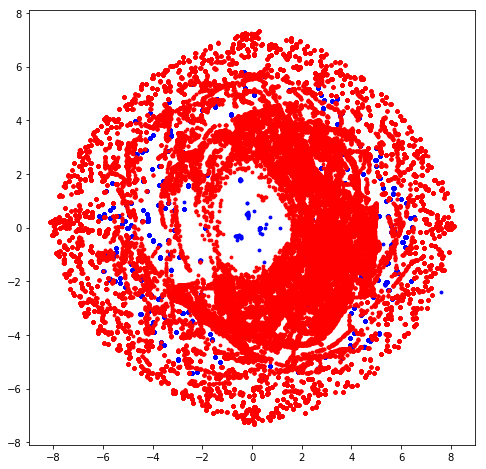

In [ ]:
for dataset in datasets:

    ## Read benign & malicious dataset        
    benign = pd.read_csv(dataset[1], na_values = missing_values)  ## benign : Type(0)
    benign = benign.dropna()
    if benign.shape[0] < 100000:          #######<<<<<<<---- change back to 150000
        benign = benign.sample(frac = 1)                
    else:
        benign = benign.sample(n = 100000) #######<<<<<<<---- change back to 150000
    c = ceil(benign.shape[0]*0.3)    
    malicious = pd.read_csv(dataset[0], na_values = missing_values)  ## malicious : Type(1)
    malicious = malicious.sample(n = c)  
    malicious = malicious.dropna()
    df = pd.concat([malicious,benign])
    del malicious, benign

    ## drop meaningless features
    df = df.drop(['Timestamp', 'DLC'], axis = 1)

    ## shuffle dataset and reset the index number.
    df = df.sample(frac = 1) 
    df = df.reset_index(drop=True)

    ## preprocess hexdecimal values to decimal values.
    for i in range(9):
        df[df.columns[i]] = df[df.columns[i]].apply(int, base=16)

    ## Define categorical columns in dataset.
    categorical_cols = []
    for col in df.columns:
        if df[col].dtypes == 'object':
            categorical_cols.append(col)

    ## Use LabelEncoder to change categorical columns' value to numeric values.
    le_cols = []
    for col in categorical_cols:
        le = LabelEncoder()
        le_cols.append(le.fit_transform(df[col]))

    ## Attach changed columns with other columns.
    le_cols = np.array(le_cols) 
    le_cols = np.transpose(le_cols)
    le_cols = pd.DataFrame(le_cols, columns = categorical_cols)
    df = df.drop(categorical_cols, axis = 1)
    df = pd.concat([le_cols, df], axis = 1)           
    del categorical_cols, le_cols

    ## seperate labels from data for training.    
    A = df.iloc[:,:-1]    ##df_data
    B = df.iloc[:,-1]    ##df_label  

    print("\n\n====================================================================================================")  
    print("<",dataset,">")
    print("Training dataset shape : ", df.shape)     
    print(" - [Original dataset] Malicious data :",B[B==1.0].index.shape[0], ", Benign data :",B[B==0.0].index.shape[0])

    ## Find optimal parameters for DBSCAN.
    dbscan_eps, dbscan_minpts = dbscan_opt_param(A, B)
    
    ## Run DBSCAN - submitting labels(B) too for getting performance scores.
    dbscan_outlier(A, B, dbscan_eps, dbscan_minpts)
    
    ## Find optimal parameters for HDBSCAN.
    hdbscan_eps, hdbscan_minpts, hdbscan_minclst = hdbscan_opt_param(A, B)
    
    ## Run HDBSCAN - submitting labels(B) too for getting performance scores.
    hdbscan_outlier(A, B, hdbscan_eps, hdbscan_minpts, hdbscan_minclst)
